In [1]:
%matplotlib inline
import numpy as np
import os
import glob
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import Sampler
from torch.utils.data import WeightedRandomSampler
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on CPU.


In [3]:
class dataset (Dataset):
    def __init__(self,train,height,width,transform=True,intensity=True,seed=42,data_path='../data'):  
        self.height = height
        self.width = width
        self.transform = transform
        self.intensity = intensity
        data_path = os.path.join(data_path, 'train' if train else 'test')
        self.image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        self.image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(self.image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.npy')
        self.rng = np.random.default_rng(seed=seed)
    
    def __len__(self):
        return len(self.image_paths) #len(self.data)
    
    def __getitem__(self,idx):        
        image_path = self.image_paths[idx]
        
        image = np.load(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]

        image = image[:,:,:7]
        
        #create a simple mask, and make everything else 0
        mask = image[:,:,4].copy()        
        mask[image[:,:,4] < 35] = 0 
        mask[image[:,:,4] >= 35] = 1
        mask[:5,:5] = 0
        image[mask==0] = 0
        
        #scale the image up to batch_size and pad remaining
        hscaler = self.height/image.shape[0]
        wscaler = self.width/image.shape[1]
        scaler = np.zeros(2)
        if hscaler > wscaler:
            image = cv2.resize(image,dsize=(0,0),fx=wscaler,fy=wscaler,interpolation=cv2.INTER_LINEAR)
            pad = self.height - image.shape[0]
            top = int(np.floor(pad * 0.5))
            bottom = int(pad-top)
            image = np.pad(image, ((top,bottom),(0,0),(0,0)), 'constant', constant_values=(0,0))
            scaler[1] = wscaler 
            
        elif hscaler < wscaler:
            image = cv2.resize(image,dsize=(0,0),fx=hscaler,fy=hscaler,interpolation=cv2.INTER_LINEAR)
            pad = self.width - image.shape[1]
            left = int(np.floor(pad * 0.5))
            right = int(pad-left)
            image = np.pad(image, ((0,0),(left,right),(0,0)), 'constant', constant_values=(0,0))
            scaler[0] = hscaler
        else:
            #Perfect fit no padding needed
            image = cv2.resize(image,dsize=(0,0),fx=wscaler,fy=hscaler,interpolation=cv2.INTER_LINEAR)
            scaler[0] = hscaler
        
        #image = cv2.resize(image,self.size,interpolation=cv2.INTER_LINEAR)
        if self.transform:
            flips = lambda x: [np.fliplr(x), np.flipud(x), np.flipud(np.fliplr(x)), x]
            image = self.rng.choice(flips(image))
        
        X = transforms.functional.to_tensor(image)
        
        if self.intensity:
            for i in range(X.shape[0]):
                X[i,:,:] = X[i,:,:]/torch.max(X[i,:,:])
#             X = X/torch.max(X)
        
        scaler = torch.from_numpy(scaler).float()
        
        return X,y,scaler
    
    def get_image_paths(self):
        return self.image_paths
    
    def get_image_classes(self):
        return self.image_classes



def make_dataloaders(height=128,width=64,batch_size=256,transform=True,intensity=True,weighted=True,seed=42):
    """
    Creates a train and test dataloader with a variable batch size and image shape.
    And using a weighted sampler for the training dataloader to have balanced mini-batches when training.
    """
    train_set = dataset(train=True,transform=transform,intensity=intensity,height=height,width=width,seed=seed)
    test_set = dataset(train=False,transform=False,intensity=intensity,height=height,width=width)
    
    if weighted:
        weights = []

        train_paths = train_set.get_image_paths()
        oat_length = len(os.listdir('../data/train/Oat'))
        wheat_length = len(os.listdir('../data/train/Wheat'))
        rye_length = len(os.listdir('../data/train/Rye'))
        broken_length = len(os.listdir('../data/train/Broken'))
        barley_length = len(os.listdir('../data/train/Barley'))

        for file in train_paths:
            label = os.path.split(os.path.split(file)[0])[1]
            if label == 'Oat':
                weights.append(0.2/oat_length)
            elif label == "Wheat":
                weights.append(0.2/wheat_length)
            elif label == "Rye":
                weights.append(0.2/rye_length)
            elif label == "Broken":
                weights.append(0.2/broken_length)
            else:
                weights.append(0.2/barley_length)
        weights = torch.FloatTensor(weights)
        sampler = WeightedRandomSampler(weights=weights,num_samples=len(train_set),replacement=False)
        train_loader = DataLoader(train_set, batch_size=batch_size,sampler=sampler, worker_init_fn=np.random.seed(seed),num_workers=4, pin_memory=True)
        
    else:
        train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True, worker_init_fn=np.random.seed(seed),num_workers=4, pin_memory=True)
        
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, worker_init_fn=np.random.seed(seed),num_workers=4, pin_memory=True)
    
    return train_loader,test_loader


In [4]:
class ResNetBlock(nn.Module):
    def __init__(self, n_features, droprate):
        super(ResNetBlock, self).__init__()
        self.conv_bn = nn.Sequential(nn.Conv2d(in_channels=n_features,out_channels=n_features,kernel_size=3,stride=1,padding=1),nn.BatchNorm2d(n_features),nn.Dropout(p=droprate))
        self.activation = nn.ReLU()
    
    def forward(self, x):
        identity = x.clone()
        x = self.conv_bn(x)
        x = self.activation(x)
        x = self.conv_bn(x)
        x = x+identity
        out = self.activation(x)
        return out

class SE_ResNetBlock(nn.Module):
    def __init__(self, n_features, droprate, r):
        super(SE_ResNetBlock, self).__init__()
        
        self.conv_bn = nn.Sequential(nn.Conv2d(in_channels=n_features,out_channels=n_features,kernel_size=3,stride=1,padding=1),nn.BatchNorm2d(n_features),nn.Dropout(p=droprate))
        self.activation = nn.ReLU()
        self.globalpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Conv2d(in_channels=n_features,out_channels=n_features//r,kernel_size=1,stride=1,padding=0) #nn.Linear(in_features=n_features,out_features=n_features//r) 
        self.fc2 = nn.Conv2d(in_channels=n_features//r,out_channels=n_features,kernel_size=1,stride=1,padding=0) #nn.Linear(in_features=n_features//r,out_features=n_features)
        self.gate = nn.Sigmoid()
    
    def forward(self, x):
        identity = x.clone()
        out = self.conv_bn(x)
        
        out = self.activation(out)
        out = self.conv_bn(out)
        
        se = self.globalpool(out) 
        se = self.fc(se)
        se = self.activation(se)
        se = self.fc2(se)
        se = self.gate(se)
        
        out = (out*se)+identity
        out = self.activation(out)
        return out

In [5]:
#Define Squeeze and Excitation ResNet
class SE_ResNet(nn.Module):
    def __init__(self, n_in, n_features, height, width, droprate, num_blocks=3,r=16):
        super(SE_ResNet, self).__init__()
        #First conv layers needs to output the desired number of features.
        conv_layers =[nn.Conv2d(n_in, n_features, kernel_size=3, stride=1, padding=1),
                      nn.Dropout(p=droprate),
                      nn.ReLU()]
        
        for i in range(num_blocks):
            conv_layers.append(SE_ResNetBlock(n_features,droprate))
            
        conv_layers.append(nn.Sequential(nn.MaxPool2d(2,2),
                                         nn.Conv2d(n_features, 2*n_features, kernel_size=3, stride=1, padding=1),
                                         nn.Dropout(p=droprate),
                                         nn.ReLU())) #Reduce image size by half
                           
        for i in range(num_blocks):
            conv_layers.append(SE_ResNetBlock(2*n_features,droprate))
            
        conv_layers.append(nn.Sequential(nn.MaxPool2d(2,2),
                                         nn.Conv2d(2*n_features, 4*n_features, kernel_size=3, stride=1, padding=1),
                                         nn.Dropout(p=droprate),
                                         nn.ReLU()))
            
        self.blocks = nn.Sequential(*conv_layers)
        
        self.fc = nn.Sequential(nn.Linear(int(height/4)*int(width/4)*4*n_features+2, 1024),
                                nn.Dropout(p=droprate),
                                nn.ReLU(),
                                nn.Linear(1024, 512),
                                nn.Dropout(p=droprate),
                                nn.ReLU(),
                                nn.Linear(512,5))
        
    def forward(self, x, scaler):
        x = self.blocks(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = cat((x,scaler),1)
        out = self.fc(x)
        return out
    
#Define Residual network
class ResNet(nn.Module):
    def __init__(self, n_in, n_features, height, width, droprate, num_blocks=3):
        super(ResNet, self).__init__()
        #First conv layers needs to output the desired number of features.
        conv_layers =[nn.Conv2d(n_in, n_features, kernel_size=3, stride=1, padding=1),
                      nn.Dropout(p=droprate),
                      nn.ReLU()]
        
        for i in range(num_blocks):
            conv_layers.append(ResNetBlock(n_features,droprate))
            
        conv_layers.append(nn.Sequential(nn.MaxPool2d(2,2),
                                         nn.Conv2d(n_features, 2*n_features, kernel_size=3, stride=1, padding=1),
                                         nn.Dropout(p=droprate),
                                         nn.ReLU())) #Reduce image size by half
                           
        for i in range(num_blocks):
            conv_layers.append(ResNetBlock(2*n_features,droprate))
            
        conv_layers.append(nn.Sequential(nn.MaxPool2d(2,2),
                                         nn.Conv2d(2*n_features, 4*n_features, kernel_size=3, stride=1, padding=1),
                                         nn.Dropout(p=droprate),
                                         nn.ReLU()))
            
        self.blocks = nn.Sequential(*conv_layers)
        
        self.fc = nn.Sequential(nn.Linear(int(height/4)*int(width/4)*4*n_features+2, 1024),
                                nn.Dropout(p=droprate),
                                nn.ReLU(),
                                nn.Linear(1024, 512),
                                nn.Dropout(p=droprate),
                                nn.ReLU(),
                                nn.Linear(512,5))
        
    def forward(self, x, scaler):
        x = self.blocks(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = cat((x,scaler),1)
        out = self.fc(x)
        return out
    
#Define convolutional network
class ConvNet(nn.Module):
    def __init__(self, n_in, n_features, height, width, droprate):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(n_in, n_features, kernel_size=3, stride=1, padding=1),                                                          
                                   nn.BatchNorm2d(n_features),
                                   nn.Dropout(p=droprate),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2,2), #Reduce image size by half  
                                   nn.Conv2d(n_features,2*n_features,3,1,1),
                                   nn.BatchNorm2d(2*n_features),
                                   nn.Dropout(p=droprate),
                                   nn.ReLU(),
                                   nn.Conv2d(2*n_features,2*n_features,3,1,1),                                 
                                   nn.BatchNorm2d(2*n_features),nn.ReLU(),
                                   nn.Dropout(p=droprate),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2,2), #Reduce image size by half
                                   nn.Conv2d(2*n_features,4*n_features,3,1,1),
                                   nn.BatchNorm2d(4*n_features),
                                   nn.Dropout(p=droprate),
                                   nn.ReLU())
        
        self.fc = nn.Sequential(nn.Linear(int(height/4)*int(width/4)*4*n_features+2, 1024),
                                nn.Dropout(p=droprate),
                                nn.ReLU(),
                                nn.Linear(1024, 512),
                                nn.Dropout(p=droprate),
                                nn.ReLU(),
                                nn.Linear(512,5))
        
    def forward(self, x, scaler):
        x = self.conv1(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = torch.cat((x,scaler),1)
        out = self.fc(x)
        return out

In [6]:
#Define focal loss    
def focal(outputs,targets,alpha=1,gamma=2):
    ce_loss = F.cross_entropy(outputs, targets, reduction='none') # important to add reduction='none' to keep per-batch-item loss
    pt = torch.exp(-ce_loss)
    focal_loss = (alpha * (1-pt)**gamma * ce_loss).mean() # mean over the batch
    return focal_loss

In [2]:
#Define the training as a function.
def train(model, optimizer, scheduler, train_loader, test_loader, device, loss_function="crossentropy",
          seed=42, batch_size='128', num_epochs=1, model_choice='ConvNet', n_features=16, height=256,
          width=128, droprate=0.5, lr=0.1, num_blocks=3, r='r', weighted=1, transform=1, intensity=1):
    if loss_function == "focal":
        lf = focal
        print("using focal loss")
    elif loss_function == "crossentropy":
        lf = F.cross_entropy
        print("using cross-entropy loss")
    else:
        sys.exit("The chosen loss function isn't valid")
    classes = test_loader.dataset.get_image_classes()
    
    writer = SummaryWriter(log_dir="../logs/" + 
    datetime.today().strftime('%d-%m-%y:%H%M') +
    f' {model_choice} {loss_function} blocks={num_blocks} features={n_features} height={height} width={width} weighted={weighted} transform={transform} intensity={intensity}')
    
    for epoch in range(num_epochs):
        print(epoch)
        model.train()
        #For each epoch
        train_correct = 0
        for minibatch_no, (data, target, scaler) in enumerate(train_loader):
            data, target, scaler = data.to(device), target.to(device), scaler.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data,scaler)
            #Compute the loss
            loss = lf(output,target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()
            
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
            
            #Remove mini-batch from memory
            del data, target, loss
#            print("mini-batch done")
        #Comput the test accuracy
        test_correct = 0
        model.eval()
        class_correct = list(0. for i in range(len(classes)))
        class_total = list(0. for i in range(len(classes)))
        for data, target,scaler in test_loader:
            data, scaler = data.to(device), scaler.to(device)
            with torch.no_grad():
                output = model(data, scaler)
            predicted = output.argmax(1).cpu()
            
            test_correct += (target == predicted).sum().item()
            
            c = (predicted == target).squeeze()
            for i in range(data.shape[0]):
                label = target[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
                
        scheduler.step()
                
        for i in range(len(classes)):
            print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))            

        Barley_Acc = 100 * class_correct[0] / class_total[0]
        Broken_Acc = 100 * class_correct[1] / class_total[1]
        Oat_Acc = 100 * class_correct[2] / class_total[2]
        Rye_Acc = 100 * class_correct[3] / class_total[3]
        Wheat_Acc = 100 * class_correct[4] / class_total[4]

        train_acc = train_correct/len(train_loader.dataset)
        test_acc = test_correct/len(test_loader.dataset)
        writer.add_scalars('Train_Test_Accuracies', {'Train_Accuracy':train_acc, 'Test_Accuracy':test_acc}, epoch)
        writer.add_scalars('Class_Accuracies', {'Barley':Barley_Acc, 'Broken':Broken_Acc, 'Oat':Oat_Acc, 'Rye':Rye_Acc, 'Wheat':Wheat_Acc}, epoch)
        
        
        print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))
        
#     writer.add_hparams({'Batch_Size':batch_size, 'Epochs':num_epochs, 'Model':model_choice, 'Loss function':loss_function, 'Features':n_features, 'Height':height, 'Width':width, 'Drop':droprate, 'LR':lr, 'Blocks':num_blocks, 'R':r, 'Weighted':weighted, 'Transform':transform, 'Intensity':intensity, 'Seed':seed}, {'hparam/Barley':Barley_Acc, 'hparam/Broken':Broken_Acc, 'hparam/Oat_Acc':Oat_Acc, 'hparam/Rye':Rye_Acc, 'hparam/Wheat':Wheat_Acc, 'hparam/Train_Accuracy':train_acc, 'hparam/Test_Accuracy':test_acc})
    
    #save model
#     torch.save(model.state_dict(), '../Models/{date}_{model_choice}_Features={features}_Blocks={blocks}_Height={height}_Width={width}'.format(date=datetime.today().strftime('%d-%m-%y:%H%M'), model_choice=model_choice, blocks=num_blocks, features=n_features, height=height, width=width))


In [8]:
#Define hyperparameters and model
r = 16
model_choice = "ConvNet" #"SE_ResNet" "ResNet" "ConvNet"
loss_function = "focal" #"crossentropy" "focal" 
num_epochs = 10
batch_size = 256 
lr = 0.01
width = 64
height = 128
droprate = 0.6
n_features = 8
num_blocks = 3
intensity = 1
transform = 1
weighted = 1

seed = np.random.randint(0,2**32-1)

metric_params = dict(batch_size=batch_size,
                     num_epochs=num_epochs,
                     model_choice=model_choice,
                     n_features=n_features,
                     height=height,
                     width=width,
                     droprate=droprate,
                     lr=lr,
                     num_blocks=num_blocks,
                     r=r,
                     weighted=weighted,
                     transform=transform,
                     intensity=intensity)
    
train_loader,test_loader = make_dataloaders(height, width, batch_size)

#initialize model and sent to device
if model_choice == "SE_ResNet":
#     from model import SE_ResNet
    model = SE_ResNet(n_in=7, n_features=n_features, height=height, width=width, droprate=droprate, num_blocks=num_blocks, r=r).float()
    model.to(device)
    print("SE_ResNet initialized")
    
elif model_choice == "ResNet":
#     from model import ResNet
    model = ResNet(n_in=7, n_features=n_features, height=height, width=width, droprate=droprate, num_blocks=num_blocks).float()
    model.to(device)
    print("ResNet initialized")
    
elif model_choice == "ConvNet":
#     from model import ConvNet
    model = ConvNet(n_in=7, n_features=n_features, height=height, width=width, droprate=droprate).float()
    model.to(device)
    print("ConvNet initialized")

else:
    sys.exit("The chosen model isn't valid")

ConvNet initialized


In [24]:
data, target,scaler = next(iter(train_loader))
for i in range(5):
    print(len(target[target==i])/len(target))

0.18359375
0.21484375
0.22265625
0.1875
0.19140625


0.2421875
0.18359375
0.2265625
0.18359375
0.1640625


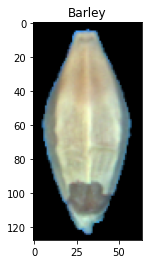

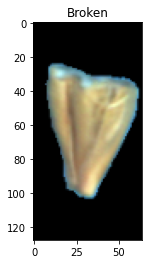

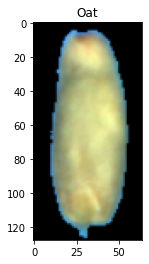

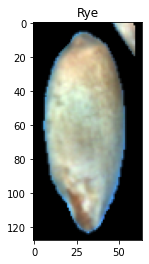

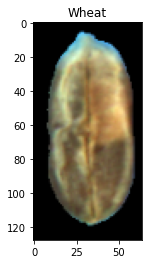

In [58]:
'''
Kanaler:
0: UV
1: Blue
2: Green
3: Orange
4: Red
5: Near IR
6: Height
7: Mask
'''
plt.imshow(np.moveaxis(data[np.where(target.numpy()==0)[0][0]].numpy(),0,2)[:,:,[4,2,1]])
plt.title("Barley")
plt.show()
plt.imshow(np.moveaxis(data[np.where(target.numpy()==1)[0][0]].numpy(),0,2)[:,:,[4,2,1]])
plt.title("Broken")
plt.show()
plt.imshow(np.moveaxis(data[np.where(target.numpy()==2)[0][0]].numpy(),0,2)[:,:,[4,2,1]])
plt.title("Oat")
plt.show()
plt.imshow(np.moveaxis(data[np.where(target.numpy()==3)[0][0]].numpy(),0,2)[:,:,[4,2,1]])
plt.title("Rye")
plt.show()
plt.imshow(np.moveaxis(data[np.where(target.numpy()==4)[0][0]].numpy(),0,2)[:,:,[4,2,1]])
plt.title("Wheat")
plt.show()

In [9]:
#initialise optimiser
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, dampening=0.05)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=int(num_epochs/2), gamma=0.1)
#run the training loop
#train(model, optimizer, train_loader=train_loader, test_loader=test_loader, device=device, num_epochs=num_epochs)
train(model, optimizer, scheduler, train_loader=train_loader, test_loader=test_loader, device=device, loss_function=loss_function, seed=seed, **metric_params)


Accuracy train: 19.7%	 test: 1.5%


In [ ]:
# #Save model
# today = datetime.today()
# torch.save(model.state_dict(), '../Models/SEResNet-{date}'.format(date=today.strftime("%I%p-%d-%h")))
# np.save('../Models/test_res_{}'.format(today.strftime("%I%p-%d-%h")),test_acc_all)
# np.save('../Models/train_res_{}'.format(today.strftime("%I%p-%d-%h")),train_acc_all)